# Tweet Clustering using K-Means

In [4]:
import numpy as np
import pandas as pd
import nltk

In [5]:
tweet = pd.read_json('tweetidn.json', lines=True)

tweet.info()
tweet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17600 entries, 0 to 17599
Data columns (total 30 columns):
created_at                   17600 non-null datetime64[ns, UTC]
id                           17600 non-null int64
id_str                       17600 non-null int64
text                         17600 non-null object
truncated                    17600 non-null bool
entities                     17600 non-null object
metadata                     17600 non-null object
source                       17600 non-null object
in_reply_to_status_id        2442 non-null float64
in_reply_to_status_id_str    2442 non-null float64
in_reply_to_user_id          2484 non-null float64
in_reply_to_user_id_str      2484 non-null float64
in_reply_to_screen_name      2484 non-null object
user                         17600 non-null object
geo                          6 non-null object
coordinates                  6 non-null object
place                        214 non-null object
contributors              

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status_id,quoted_status_id_str,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status,extended_entities
0,2020-01-30 19:30:57+00:00,1222965439417815041,1222965439417815040,RT @cursedkidd: ternyata sunda empire itu sebe...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,1.222508e+18,1.222508e+18,1351,0,False,False,in,NaN,NaN,NaN
1,2020-01-30 19:30:23+00:00,1222965297323184128,1222965297323184128,@selvyardp @ngalamfess Di Kekaisaran sunda emp...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.222965e+18,1.222965e+18,...,NaN,NaN,0,0,False,False,in,NaN,NaN,NaN
2,2020-01-30 19:29:53+00:00,1222965171418615808,1222965171418615808,@emnashrullah RAJA RAJA PALSU NUSANTARA \n====...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.222896e+18,1.222896e+18,...,NaN,NaN,0,0,False,False,in,0.0,NaN,NaN
3,2020-01-30 19:28:05+00:00,1222964719360724992,1222964719360724992,@detikcom RAJA RAJA PALSU NUSANTARA \n========...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.222959e+18,1.222959e+18,...,NaN,NaN,0,0,False,False,in,0.0,NaN,NaN
4,2020-01-30 19:26:27+00:00,1222964309438783488,1222964309438783488,@cekristn W titisan sunda empire😠,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.222914e+18,1.222914e+18,...,NaN,NaN,0,0,False,False,in,NaN,NaN,NaN


In [6]:
txt = tweet.loc[0:2000]['text'][tweet['truncated']==False][tweet['lang']=='in']

txt.head()

0    RT @cursedkidd: ternyata sunda empire itu sebe...
1    @selvyardp @ngalamfess Di Kekaisaran sunda emp...
4                    @cekristn W titisan sunda empire😠
5    Emangnya bener ya orang sunda empire yg di ILC...
7            @RFyani_ Jang daftar sunda empire wowkwos
Name: text, dtype: object

In [7]:
txt.shape

(1729,)

In [8]:
import re

# Remove punctuation
txt_pre = txt.map(lambda x: re.sub('[,\.!?:@#]', '', x))

# Convert to lowercase
txt_prep = txt_pre.map(lambda x: x.lower())

In [9]:
txt_prep

0       rt cursedkidd ternyata sunda empire itu sebena...
1       selvyardp ngalamfess di kekaisaran sunda empir...
4                        cekristn w titisan sunda empire😠
5       emangnya bener ya orang sunda empire yg di ilc...
7                rfyani_ jang daftar sunda empire wowkwos
                              ...                        
1994    katolikg jakarta  ke mabes polri nemuin peting...
1996                      receinaja penduduk sunda empire
1997    rt abaheayman pernyataan ust ismail yusanto\nf...
1998    rt kadrunhunter99 maybe si aniesbaswedan ini l...
2000    rt detikcom perdana menteri sunda empire nasri...
Name: text, Length: 1729, dtype: object

In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [11]:
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

In [12]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer parameters for efficient processing of text.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

In [14]:
# Fit and transform the tfidf_vectorizer to create a vector representation of the tweet summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in txt_prep])

print(tfidf_matrix.shape)


(1729, 122)


In [163]:
from scipy.cluster.vq import kmeans

num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 5 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:5])

['https', 'sama', 'rt', 'empire https', 'raja']
['rt', 'nyata', 'benar', 'king', 'detikcom']


In [155]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


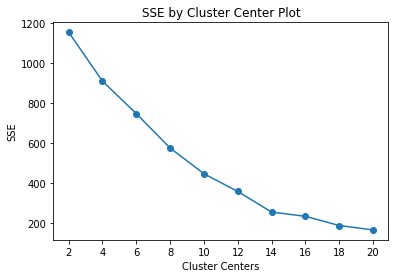

In [156]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tfidf_matrix, 20)

In [174]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_matrix)

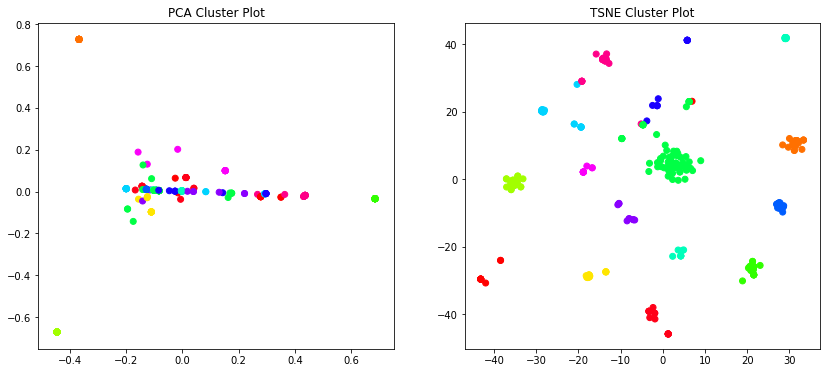

In [176]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1700, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tfidf_matrix, clusters)

In [178]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_matrix, clusters, tfidf_vectorizer.get_feature_names(), 10)


Cluster 0
jurus kemahameha,jurus kemahameha kagebunshin,juta,jadi,sama,runtuh,ga,nyata,rt,detikcom

Cluster 1
rapi news wawancara,sama mas tony,sama mas,rapi news wawancara ekslusif,ekslusif,ekslusif sunda,ekslusif sunda empire,rt rapi news wawancara,mas tony,wawancara ekslusif sunda

Cluster 2
https,sama,kagebunshin,kagebunshin https,bayar,kamehameha,formulir,daftar sunda empire,daftar sunda,daftar

Cluster 3
jurus kemahameha,minta bayar rp,rp juta,kemahameha kagebunshin https,rt kumpar dal,empire minta bayar,empire minta,sunda empire minta,minta bayar,kuasa jurus kemahameha

Cluster 4
jadi,https tco nk8vad9tz5,https tco ch5xhwiv9d,https tco,https,gepeng kesana kesini,gepeng kesana,kagebunshin,wawancara ekslusif sunda,rt

Cluster 5
kuasa,kumpar,formulir,daftar,kamehameha,rt,https,runtuh,aja,ga

Cluster 6
https,rt,ga,aja,of the,king of the,king of,the,of,king

Cluster 7
jurus kemahameha kagebunshin,juta,juta kuasa,jurus kemahameha,wawancara ekslusif sunda,jadi,nyata,formulir,rt,https


## Conclusion and Analysis

In the Twitter data this time I took a cluster of n = 14 based on the elbow graph on the 'SSE by Cluster Center Plot' graph.

It was shown that the preprocessing data that was carried out was still not optimal and could still be refined using methods or regular expressions that were more suitable for tweet data.